# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/

Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

In [11]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report

from sklearn import neighbors, metrics

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

Load the data. Notice that we are splitting the data into training, development, and test. We also have a small subset of the training data called mini_train_data and mini_train_labels that you should use in all the experiments below, unless otherwise noted.

In [4]:
# Load the digit data either from mldata.org, or once downloaded to data_home, from disk. The data is about 53MB so this cell
# should take a while the first time your run it.
mnist = fetch_mldata('MNIST original', data_home='~/datasets/mnist')
X, Y = mnist.data, mnist.target

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


In [8]:
mini_train_data


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

(1) Create a 10x10 grid to visualize 10 examples of each digit. Python hints:

- plt.rc() for setting the colormap, for example to black and white
- plt.subplot() for creating subplots
- plt.imshow() for rendering a matrix
- np.array.reshape() for reshaping a 1D feature vector into a 2D matrix (for rendering)

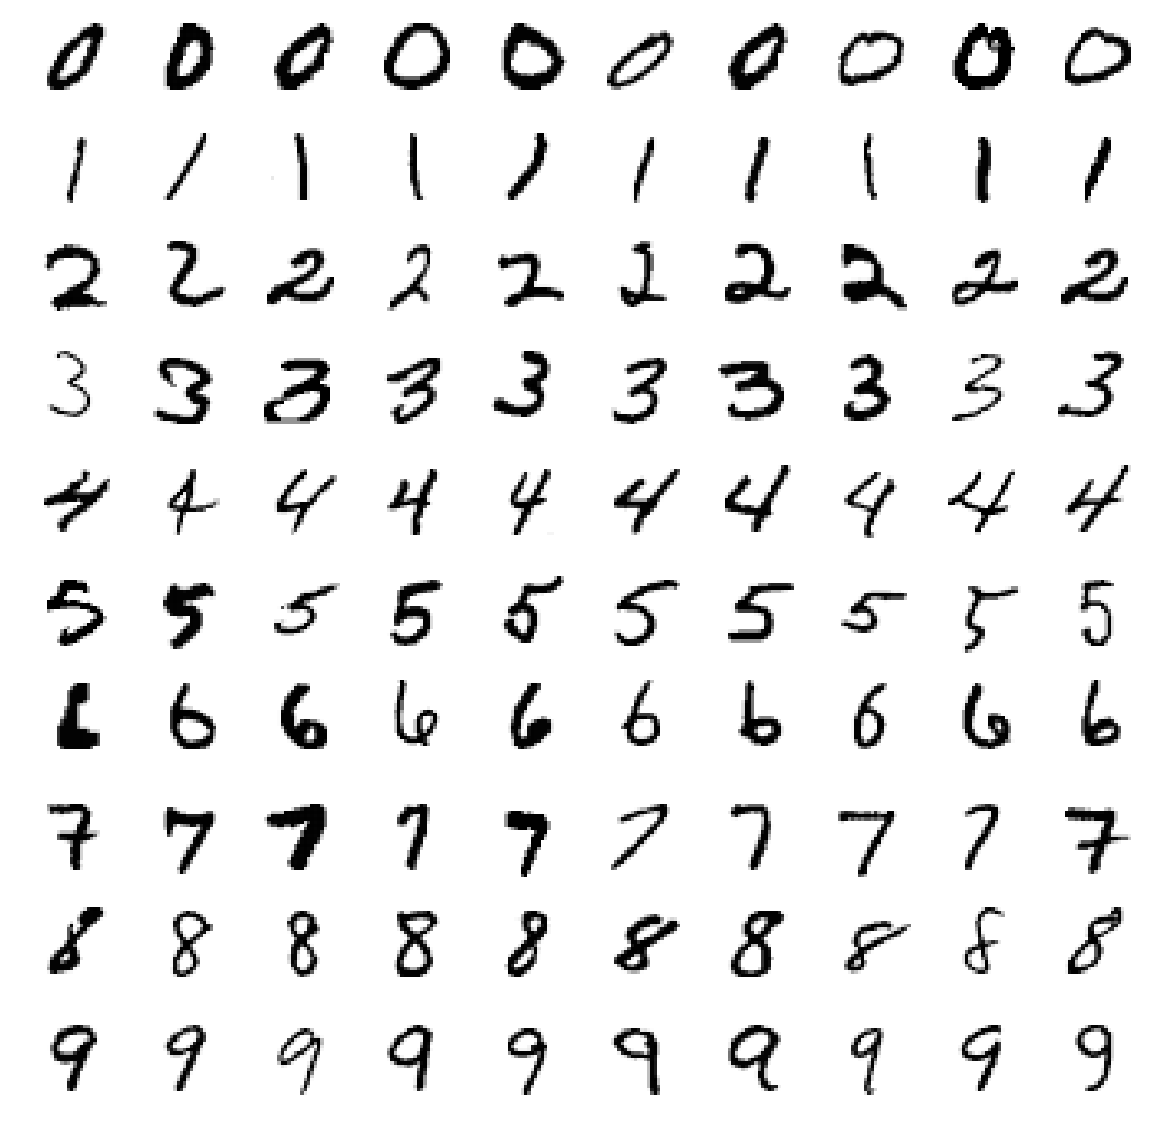

In [307]:
def P1(num_examples):
    
    plt.rc('image', cmap='Greys')
    plt.figure(figsize=(20, 20))
    fignum = 1

    for j in range(len(np.unique(mini_train_labels))):
        for i in range(num_examples):
            img = mini_train_data[np.random.choice(np.where(mini_train_labels == j)[0], 1)].reshape(28, 28)    

            plt.subplot(10, num_examples, fignum)
            fignum += 1
            plt.axis('off')
            plt.imshow(img)

    plt.show()

P1(10)

(2) Evaluate a K-Nearest-Neighbors model with k = [1,3,5,7,9] using the mini training set. Report accuracy on the dev set. For k=1, show precision, recall, and F1 for each label. Which is the most difficult digit?

- KNeighborsClassifier() for fitting and predicting
- classification_report() for producing precision, recall, F1 results

In [43]:
def P2(k_values):

### STUDENT START ###

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k).fit(mini_train_data,mini_train_labels)
        accuracy = knn.score(X = dev_data, y = dev_labels) 
        print("k = ", str(k), " has accuracy of: ", str(accuracy))


    knn = KNeighborsClassifier(n_neighbors=1).fit(mini_train_data, mini_train_labels)
    knn_preds = knn.predict(dev_data)
    print(classification_report(y_true = dev_labels, y_pred = knn_preds))

### STUDENT END ###

k_values = [1, 3, 5, 7, 9]
P2(k_values)

k =  1  has accuracy of:  0.888
k =  3  has accuracy of:  0.878
k =  5  has accuracy of:  0.869
k =  7  has accuracy of:  0.865
k =  9  has accuracy of:  0.863
             precision    recall  f1-score   support

        0.0       0.91      0.98      0.94        99
        1.0       0.89      1.00      0.94       105
        2.0       0.99      0.79      0.88       102
        3.0       0.77      0.87      0.82        86
        4.0       0.89      0.82      0.85       104
        5.0       0.93      0.84      0.88        91
        6.0       0.94      0.96      0.95        98
        7.0       0.89      0.92      0.90       113
        8.0       0.94      0.88      0.91        96
        9.0       0.78      0.82      0.80       106

avg / total       0.89      0.89      0.89      1000



ANSWER: K=1 had the highest accuracy. The accuracy of the model decreased as more neighbors where taken into account. Nine is the hardest digit to classify when k=1 according to the f1-score. 

(3) Using k=1, report dev set accuracy for the training set sizes below. Also, measure the amount of time needed for prediction with each training size.

- time.time() gives a wall clock value you can use for timing operations

In [42]:
def P3(train_sizes, accuracies):

### STUDENT START ###

    for size in train_sizes:
        start_time = time.time() # Set the start time at the beginning of the process

        # Create the model
        knn = KNeighborsClassifier(n_neighbors=1).fit(train_data[:size], train_labels[:size])
        knn_preds = knn.predict(dev_data)
        accuracy = knn.score(X = dev_data, y = dev_labels) # Calculate the accuracy
        run_time = round(time.time() - start_time, 3) # Calculate the run time
        accuracies.append(accuracy) # Store the accuracy in a list

        # Print the results
        print("Training size:", str(size), "\t", "Accuracy: ", \
        str(accuracy), "\t", "Run time: ", str(run_time), " seconds")


### STUDENT END ###

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25000]
accuracies = []
P3(train_sizes, accuracies)

Training size: 100 	 Accuracy:  0.72 	 Run time:  0.243  seconds
Training size: 200 	 Accuracy:  0.786 	 Run time:  0.43  seconds
Training size: 400 	 Accuracy:  0.841 	 Run time:  0.868  seconds
Training size: 800 	 Accuracy:  0.884 	 Run time:  1.741  seconds
Training size: 1600 	 Accuracy:  0.902 	 Run time:  3.5  seconds
Training size: 3200 	 Accuracy:  0.926 	 Run time:  7.036  seconds
Training size: 6400 	 Accuracy:  0.937 	 Run time:  14.519  seconds
Training size: 12800 	 Accuracy:  0.959 	 Run time:  29.261  seconds
Training size: 25000 	 Accuracy:  0.97 	 Run time:  58.886  seconds


(4) Fit a regression model that predicts accuracy from training size. What does it predict for n=60000? What's wrong with using regression here? Can you apply a transformation that makes the predictions more reasonable?

- Remember that the sklearn fit() functions take an input matrix X and output vector Y. So each input example in X is a vector, even if it contains only a single value.

Prediction of accuracy for k = 60000: 1.24307226036


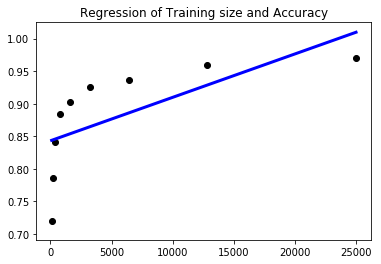

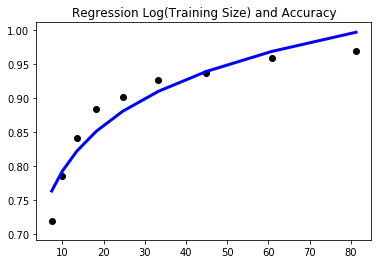

In [41]:
def P4():

### STUDENT START ###

    #Put data into array
    train_sizes_ar = np.asarray(train_sizes)
    accuracies_ar = np.asarray(accuracies)

    # Reshape arrays
    accuracies_ar = accuracies_ar.reshape(-1,1)
    train_sizes_ar = train_sizes_ar.reshape(-1,1)

    # Fit a linear regression model
    train_accuracy = LinearRegression().fit(train_sizes_ar, accuracies_ar)

    # Predict 60K training size
    predict_60k = train_accuracy.predict(60000)
    print("Prediction of accuracy for k = 60000: " + str(predict_60k[0][0]))

    # Plot results
    plt.scatter(train_sizes_ar, accuracies_ar,  color='black')
    plt.plot(train_sizes_ar, train_accuracy.predict(train_sizes_ar), color='blue',
             linewidth=3)
    plt.title("Regression of Training size and Accuracy")
    plt.show()

    # Log of training size
    train_log = np.log10(train_sizes_ar)

    # Model of log of training size
    train_accuracy_log = LinearRegression().fit(train_log, accuracies_ar)

    # Plot results
    plt.scatter(np.exp(train_log), accuracies_ar,  color='black')
    plt.plot(np.exp(train_log), train_accuracy_log.predict(train_log), color='blue',
            linewidth=3)
    plt.title("Regression Log(Training Size) and Accuracy")
    plt.show()

### STUDENT END ###

P4()

ANSWER: The regression is predicting an accuracy of greater than one for a training size of 60K. Accuracy cannot be greater than one. To resolve this use fit the log base 10 to the training size. 

Fit a 1-NN and output a confusion matrix for the dev data. Use the confusion matrix to identify the most confused pair of digits, and display a few example mistakes.

- confusion_matrix() produces a confusion matrix

Confusion Matrix
[[ 97   0   0   0   0   0   2   0   0   0]
 [  0 105   0   0   0   0   0   0   0   0]
 [  4   4  81   4   0   0   0   4   3   2]
 [  1   0   0  75   0   3   0   3   1   3]
 [  0   2   0   0  85   0   3   0   0  14]
 [  2   0   0   9   0  76   0   1   1   2]
 [  1   1   1   0   1   0  94   0   0   0]
 [  1   4   0   1   1   0   0 104   0   2]
 [  0   2   0   5   0   2   1   0  84   2]
 [  1   0   0   3   9   1   0   5   0  87]]
The most commonly confused digits where 4 being predicted as a 9


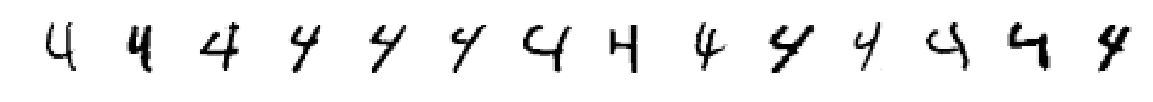

In [309]:
def P5(k):
    knn = KNeighborsClassifier(n_neighbors=k).fit(mini_train_data,mini_train_labels)
    knn_preds = knn.predict(dev_data)
    cm = confusion_matrix(dev_labels, knn_preds)

    print("Confusion Matrix")
    print(cm)

    wrong_pred = np.intersect1d(np.where(knn_preds == 9), np.where(dev_labels == 4))    


    plt.figure(figsize=(20, 20))
    fignum = 1
    print("The most commonly confused digits where 4 being predicted as a 9")
    for j in wrong_pred:
        plt.subplot(1, len(wrong_pred), fignum)
        fignum += 1
        plt.axis('off')
        plt.imshow(dev_data[j].reshape(28, 28))

    plt.show()
P5(1) 

(6) A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian -- that is, the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur by just using the 8 neighboring pixels: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values. Try applying your blur filter in 3 ways:
- preprocess the training data but not the dev data
- preprocess the dev data but not the training data
- preprocess both training and dev data

Note that there are Guassian blur filters available, for example in scipy.ndimage.filters. You're welcome to experiment with those, but you are likely to get the best results with the simplified version I described above.

In [301]:
 def P6():
    def Neighbors(pixel, edge = 28):
        # Loop through all pixels and determine surrounding pixels. 
        #If surrounding pixel isn't in image, less than 0 or GT then image frame (28) then remove.
        
        x = int(pixel/edge)
        y = pixel - (x * edge)
        
        n = [None] * 8
        n[0] = (x-1, y-1)
        n[1] = (x-1, y)
        n[2] = (x-1, y+1)
        n[3] = (x, y-1)
        n[4] = (x, y+1)
        n[5] = (x+1, y-1)
        n[6] = (x+1, y)
        n[7] = (x+1, y+1)
          
        nghb = [n[i] for i in range(8) if n[i][0] >= 0 and n[i][1] >= 0 and n[i][0] < edge and n[i][1] < edge]
        pixels = [nghb[i][0]*edge + nghb[i][1] for i in range(len(nghb))]
        return pixels

    def smooth(img):
        blr = np.array(img)
        for i in range(len(img)):
            ngbhrs = img[Neighbors(i)]        
            blr[i] = sum(ngbhrs) / len(ngbhrs)        
        return blr

# Pre-processing train data
    blur_train_data = np.array(mini_train_data)
    for i, val in enumerate(blur_train_data):
        blur_train_data[i] = smooth(val)

# Pre-processing dev data
    blur_dev_data = np.array(dev_data)
    for i, val in enumerate(blur_dev_data):
        blur_dev_data[i] = smooth(val)    

# Calculating Accuracy
# With blurring training only
    model = KNeighborsClassifier(n_neighbors = 1)
    model.fit(blur_train_data, mini_train_labels)
    print('Accuracy: Blurred training data only:', model.score(dev_data, dev_labels))

# With blurring dev data only
    model = KNeighborsClassifier(n_neighbors = 1)
    model.fit(mini_train_data, mini_train_labels)
    print('Accuracy: Blurred dev data only:', model.score(blur_dev_data, dev_labels))   

# # With blurring Blur both dev and training
    model = KNeighborsClassifier(n_neighbors = 1)
    model.fit(blur_train_data, mini_train_labels)
    print('Accuracy: Blurred both dev and training data:', model.score(blur_dev_data, dev_labels))
P6()
### STUDENT END ###

Accuracy: Blurred training data only: 0.911
Accuracy: Blurred dev data only: 0.867
Accuracy: Blurred both dev and training data: 0.903


ANSWER: Blurring the training data only did slightly better than the other combinations. blurring the dev data only did the worst. 

(7) Fit a Naive Bayes classifier and report accuracy on the dev data. Remember that Naive Bayes estimates P(feature|label). While sklearn can handle real-valued features, let's start by mapping the pixel values to either 0 or 1. You can do this as a preprocessing step, or with the binarize argument. With binary-valued features, you can use BernoulliNB. Next try mapping the pixel values to 0, 1, or 2, representing white, grey, or black. This mapping requires MultinomialNB. Does the multi-class version improve the results? Why or why not?

In [62]:
def P7():

### STUDENT START ###

# BernoulliNB
    def bernNB():
        bnb = BernoulliNB(binarize=.5)
        bnb.fit(mini_train_data, mini_train_labels)
        print('BernoulliNB Accuracy:', bnb.score(dev_data, dev_labels)) 
    
    def multiNB():
        transdata = np.array(mini_train_data)
        for rowindex, rowvalue in enumerate(transdata):
            for columnindex, columnvalue in enumerate(rowvalue):
                if columnvalue <= 1/3:
                    transdata[rowindex, columnindex] = 0
                elif columnvalue <= 2/3:
                    transdata[rowindex, columnindex] = 1
                else:
                    transdata[rowindex, columnindex] = 2
            
        mnb = MultinomialNB().fit(transdata, mini_train_labels)
        print('MultinomialNB Accuracy:', mnb.score(dev_data, dev_labels))
        
    bernNB()
    multiNB()
### STUDENT END ###

P7()

BernoulliNB Accuracy: 0.815
MultinomialNB Accuracy: 0.797


ANSWER: The multinomialNB doesn't improve the accuracy of the model. Teh vast majority of the pixels don't have a color. The areas that are colored are likely to be very dark very quickly as a result the additional dimension of the multinomialNB doesn't help the prediction. However, if the image classification where something with a more even spectrum of colors, it might help the prediction. 

(8) Use GridSearchCV to perform a search over values of alpha (the Laplace smoothing parameter) in a Bernoulli NB model. What is the best value for alpha? What is the accuracy when alpha=0? Is this what you'd expect?

- Note that GridSearchCV partitions the training data so the results will be a bit different than if you used the dev data for evaluation.

In [306]:
def P8(alphas):

### STUDENT START ###

    bnb = BernoulliNB(binarize=0.5)
    bnb_cv = GridSearchCV(bnb, alphas).fit(mini_train_data, mini_train_labels)

    for params, score, l in bnb_cv.grid_scores_:
        print(params, "Accuracy: ", score)
        
    print("Best Alpha: ", bnb_cv.best_params_, "Score: ", bnb_cv.best_score_ )
### STUDENT END ###

alphas = {'alpha': [0.0, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)

/Users/klomurray/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/klomurray/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
/Users/klomurray/anaconda3/lib/python3.6/site-packages/sklearn/naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


{'alpha': 0.0} Accuracy:  0.803
{'alpha': 0.0001} Accuracy:  0.818
{'alpha': 0.001} Accuracy:  0.82
{'alpha': 0.01} Accuracy:  0.821
{'alpha': 0.1} Accuracy:  0.815
{'alpha': 0.5} Accuracy:  0.8
{'alpha': 1.0} Accuracy:  0.795
{'alpha': 2.0} Accuracy:  0.784
{'alpha': 10.0} Accuracy:  0.72
Best Alpha:  {'alpha': 0.01} Score:  0.821


In [72]:
#print(nb.best_params_)

AttributeError: 'NoneType' object has no attribute 'best_params_'

ANSWER: The best alpha is 0.01. The accuracy when alpha is 0 causes a numeric error so python sets alpha to a small number similar to 0.0001. 

(9) Try training a model using GuassianNB, which is intended for real-valued features, and evaluate on the dev data. You'll notice that it doesn't work so well. Try to diagnose the problem. You should be able to find a simple fix that returns the accuracy to around the same rate as BernoulliNB. Explain your solution.

Hint: examine the parameters estimated by the fit() method, theta\_ and sigma\_.

In [94]:
def P9():

### STUDENT END ###
    
    #Generate Gaussian Naive Baayes
    gnb = GaussianNB().fit(mini_train_data, mini_train_labels)
    pred_labels = gnb.predict(dev_data)
    print("GaussianNB accuracy:", gnb.score(dev_data, dev_labels))
    
    #Print theta and sigma for GNB    
    print('theta: {theta}\n sigma: {sigma}\n'.format(theta=gnb.theta_,sigma=gnb.sigma_))
    
    #Add noise to the training and dev data
    train_noise = np.random.normal(mini_train_data.mean(), np.std(mini_train_data), mini_train_data.shape)
    train_data_w_noise = np.array(mini_train_data + train_noise)
    gnb = GaussianNB().fit(train_data_w_noise, mini_train_labels)

    dev_noise = np.random.normal(mini_train_data.mean(), np.std(mini_train_data), dev_data.shape)
    dev_data_w_noise = np.array(dev_data + dev_noise)
    
    print("GaussianNB accuracy with noise:", gnb.score(dev_data_w_noise, dev_labels))
    
### STUDENT END ###

gnb = P9()

GaussianNB accuracy: 0.621
theta: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
 sigma: [[  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 ..., 
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]
 [  1.98697608e-10   1.98697608e-10   1.98697608e-10 ...,   1.98697608e-10
    1.98697608e-10   1.98697608e-10]]

GaussianNB accuracy with noise: 0.806


ANSWER: This model assumes normally distributed features. However, a large number have a color score of zero. This leads the data to not be normal. We need to add noise to the data to overcome this limitation. 

(10) Because Naive Bayes is a generative model, we can use the trained model to generate digits. Train a BernoulliNB model and then generate a 10x20 grid with 20 examples of each digit. Because you're using a Bernoulli model, each pixel output will be either 0 or 1. How do the generated digits compare to the training digits?

- You can use np.random.rand() to generate random numbers from a uniform distribution
- The estimated probability of each pixel is stored in feature\_log\_prob\_. You'll need to use np.exp() to convert a log probability back to a probability.

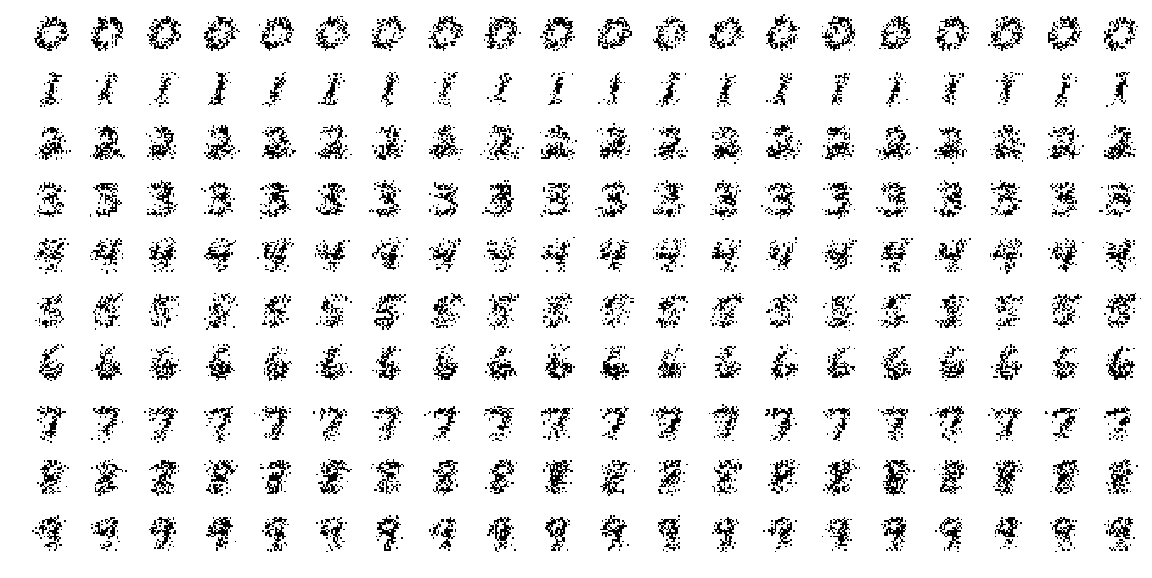

In [310]:
def P10(num_examples):

### STUDENT START ###

    bnb = BernoulliNB(alpha = 0.0001, binarize = 0.5).fit(mini_train_data, mini_train_labels)   
        
    plt.figure(figsize=(20, 10))
    for i in range(bnb.feature_log_prob_.shape[0]):
        for k in range(num_examples):
            random_probs = np.random.rand(bnb.feature_log_prob_.shape[1])
            image = 1*(np.exp(bnb.feature_log_prob_[i]) > random_probs)
            fignum = i*num_examples + (k+1)
            plt.subplot(10, num_examples, fignum)
            plt.axis('off')
            plt.imshow(image.reshape(28, 28))
### STUDENT END ###

P10(20)

ANSWER: The generated digits are fuzzier than the training digits. For some digits such as zero they are fairly consistent, but for digits such as 2 and 5 they become a wash of blur. 

(11) Remember that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior and accuracy.

Train a BernoulliNB model with a reasonable alpha value. For each posterior bucket (think of a bin in a histogram), you want to estimate the classifier's accuracy. So for each prediction, find the bucket the maximum posterior belongs to and update the "correct" and "total" counters.

How would you characterize the calibration for the Naive Bayes model?

In [129]:
def P11(buckets, correct, total):
    
### STUDENT START ###
    bnb = BernoulliNB(alpha = 0.0001, binarize = 0.5).fit(mini_train_data, mini_train_labels)
    pred_labels = bnb.predict(dev_data)
    probability = bnb.predict_proba(dev_data)
     
    for i, bucket in enumerate(buckets):
        for k, value in enumerate(probability):
            if value.max() <= bucket and value.max() > 0:
                total[i] += 1
                if pred_labels[k] == dev_labels[k]:
                    correct[i] += 1
        prev_bucket = bucket

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): accuracy = correct[i] / total[i]
    print('p(pred) <= %.13f    total = %3d    accuracy = %.3f' %(buckets[i], total[i], accuracy))

p(pred) <= 0.5000000000000    total =   0    accuracy = 0.000
p(pred) <= 0.9000000000000    total =  34    accuracy = 0.324
p(pred) <= 0.9990000000000    total = 113    accuracy = 0.416
p(pred) <= 0.9999900000000    total = 187    accuracy = 0.465
p(pred) <= 0.9999999000000    total = 255    accuracy = 0.537
p(pred) <= 0.9999999990000    total = 306    accuracy = 0.578
p(pred) <= 0.9999999999900    total = 370    accuracy = 0.616
p(pred) <= 0.9999999999999    total = 434    accuracy = 0.657
p(pred) <= 1.0000000000000    total = 1000    accuracy = 0.817


ANSWER: The BernoulliNB model is a weak classifier. As the posterior probabability increases the accuracy goes up. For a strongly callibrated classier we'd expect a posterior probablility of 0.9 should be 90% accurate, but in our model its only 32.4% accuracate. 

(12) EXTRA CREDIT

Try designing extra features to see if you can improve the performance of Naive Bayes on the dev set. Here are a few ideas to get you started:
- Try summing the pixel values in each row and each column.
- Try counting the number of enclosed regions; 8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0.

Make sure you comment your code well!

In [ ]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()